# HR Analytics

### Loading Packages

In [1]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date
from IPython.display import display
pd.set_option('display.max_columns', None)
from datetime import datetime
from dateutil.parser import parse
from scipy.stats import entropy
from math import log, e
import warnings

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})
warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.model_selection import KFold
from sklearn import metrics

### Custom Functions

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def get_stats(df,columns, bins):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column], bins=bins)
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=bins, alpha=0.5, ax=axs[1])
        
def target_encode(df_tr, columns):
    for col in columns:
        print(col)
        cumsum = df_tr.groupby(col)['is_promoted'].cumsum() -  df_tr['is_promoted']
        cumcnt = df_tr.groupby(col).cumcount()
        df_tr[col+'_mean_target'] = cumsum/cumcnt
        df_tr[col+'_mean_target'].fillna(df_tr[col+'_mean_target'].mean(),inplace=True)
    return df_tr

### Loading dataset

In [5]:
Path = './data/HR_Analytics/'

In [6]:
%%time
train = pd.read_csv(f'{Path}train.csv')
test = pd.read_csv(f'{Path}test.csv')
submission = pd.read_csv(f'{Path}sample_submission.csv')

CPU times: user 102 ms, sys: 23.3 ms, total: 126 ms
Wall time: 125 ms


### Structure of Data

In [7]:
train.shape, test.shape

((54808, 14), (23490, 13))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


## Basic summary statistics

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.0,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.00,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.00,33.0,39.0,60.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.00,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.00,5.0,7.0,37.0
KPIs_met >80%,54808.0,0.351974,0.477590,0.0,0.00,0.0,1.0,1.0
awards_won?,54808.0,0.023172,0.150450,0.0,0.00,0.0,0.0,1.0
avg_training_score,54808.0,63.386750,13.371559,39.0,51.00,60.0,76.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.00,0.0,0.0,1.0


In [10]:
display_all(train.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


## Data Preprocessing

#### Check for columns with missing values in dataset

In [11]:
for df in (train, test):
    missing_stats = df.isnull().sum(axis=0)
    print(missing_stats[missing_stats != 0], '\n')

education               2409
previous_year_rating    4124
dtype: int64 

education               1034
previous_year_rating    1812
dtype: int64 



In [12]:
for df in (train, test):
    df['education'].fillna("Other", inplace=True)
    df['previous_year_rating'].fillna(3, inplace=True)

In [13]:
numeric_columns = ['no_of_trainings', 'age', 'previous_year_rating' ,'length_of_service' ,'KPIs_met >80%',
                   'awards_won?' ,'avg_training_score']
categorical_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel']

### Exploratory Data Analysis

#### Proportion of fraud transactions in the dataset

In [14]:
train['is_promoted'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [15]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10465fc18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c011b70>]], dtype=object)

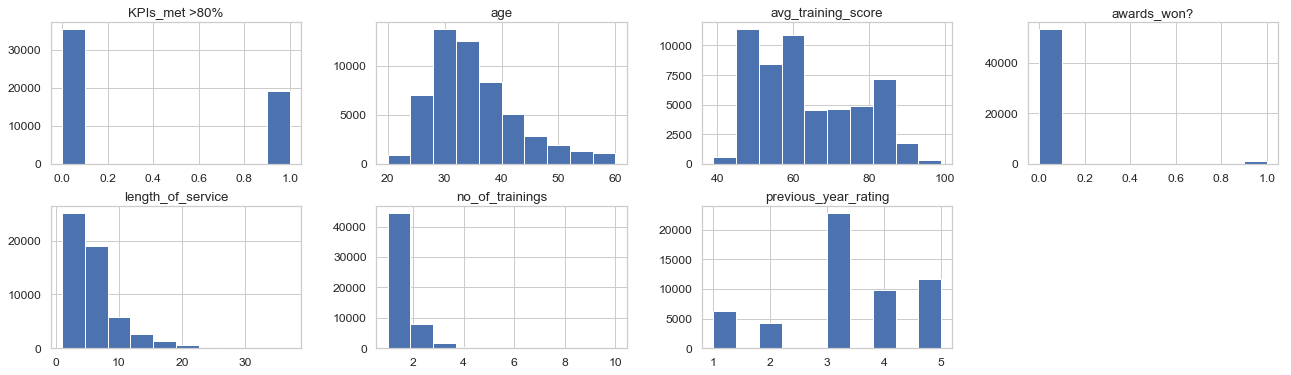

In [16]:
train[numeric_columns].hist(figsize=(22, 6), layout=(2, 4))

#### Boxplots to understand the quantiles in the numeric columns also used to check for outliers

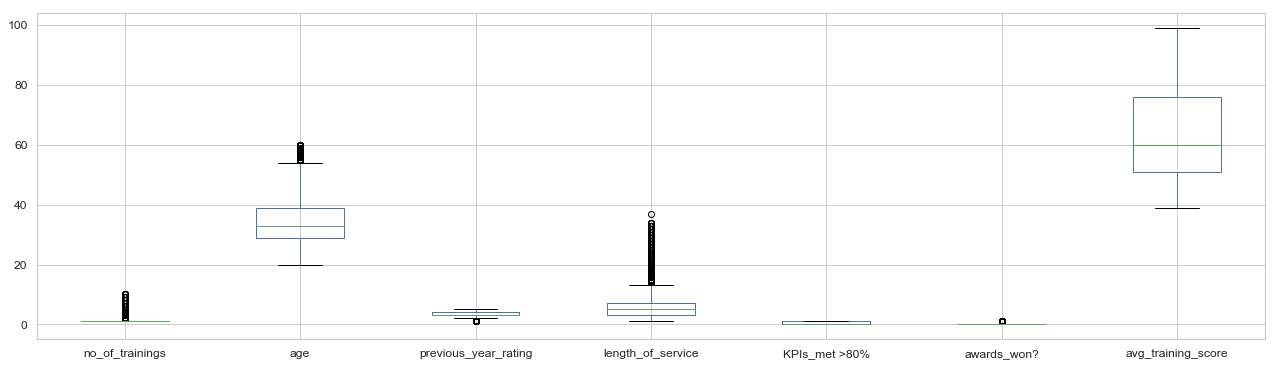

In [17]:
train[numeric_columns].boxplot(figsize=(22, 6))

### Visualizing distribution of promotions in the categorical columns using stacked bar charts

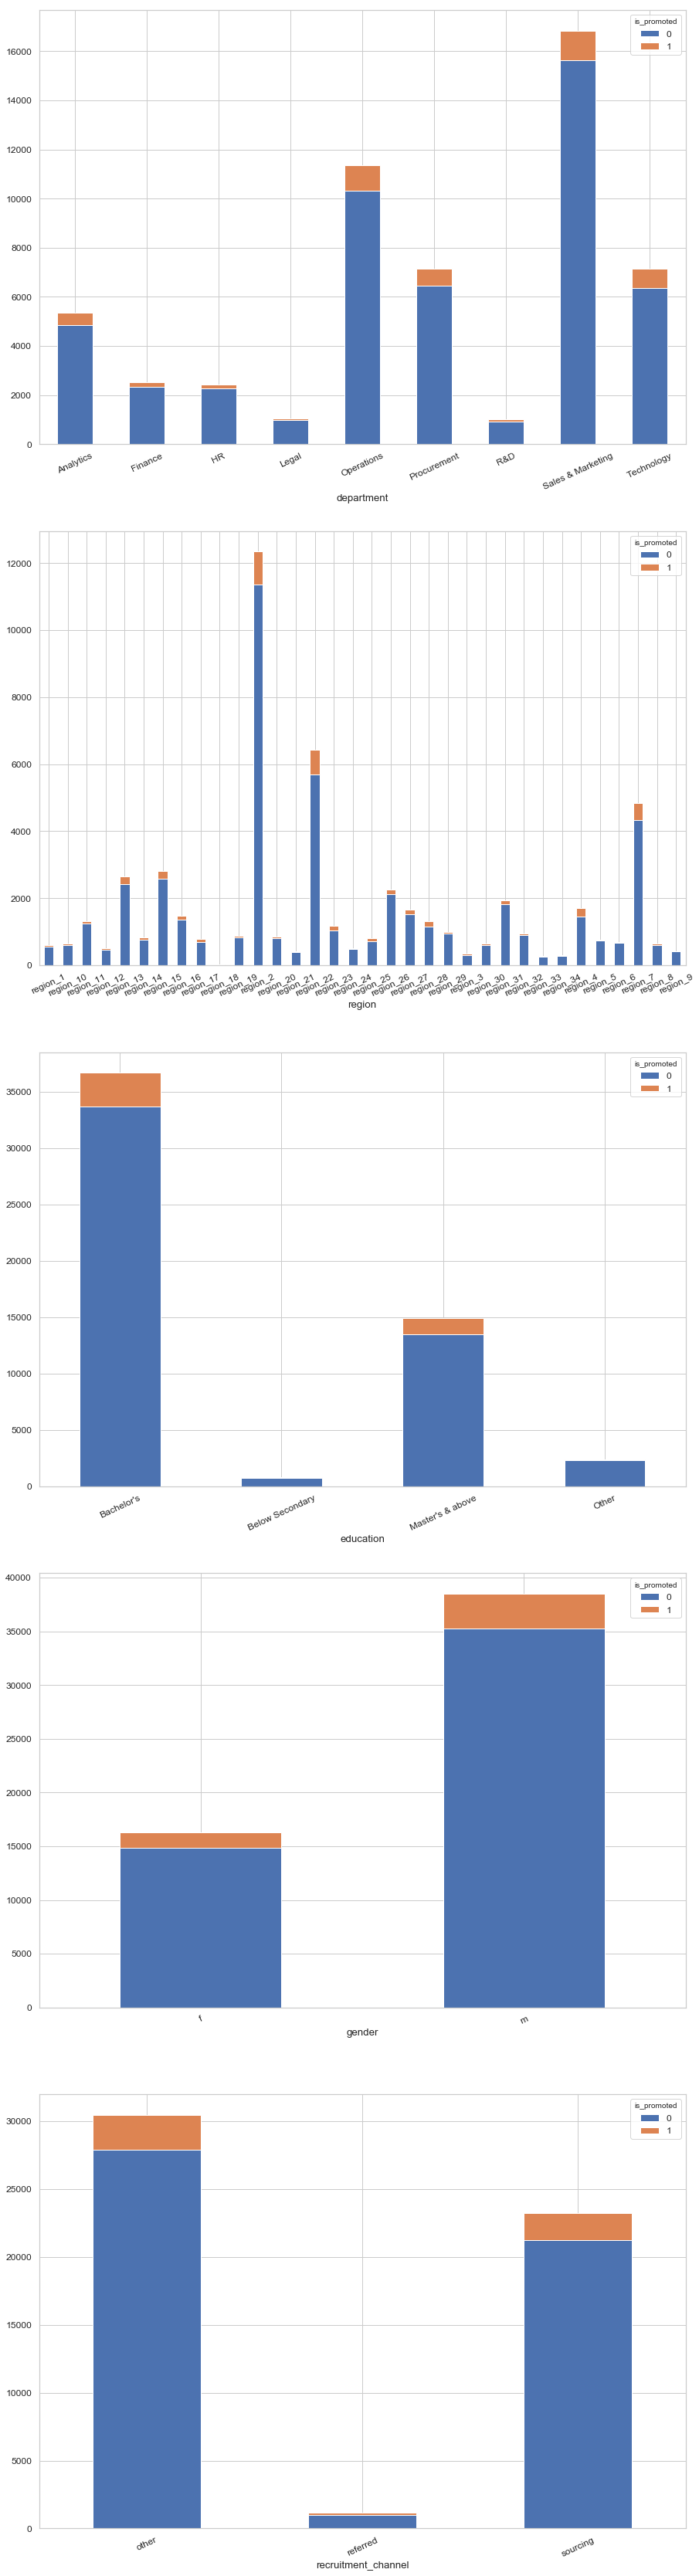

In [18]:
fig, ax = plt.subplots(len(categorical_columns), figsize=(15, 60))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    ct = pd.crosstab(train[variable], train['is_promoted'])
    ct.plot.bar(stacked=True, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(25)

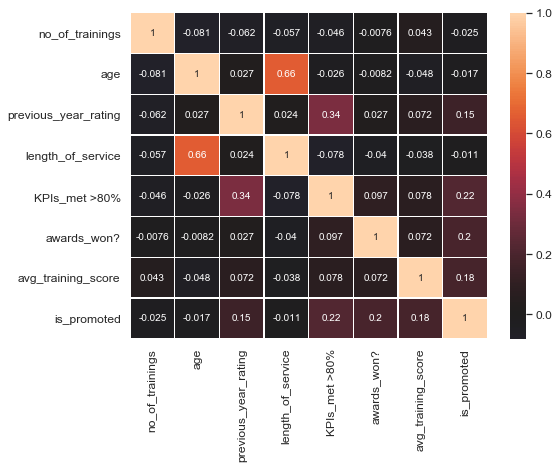

In [19]:
#creating a heatmap of the attributes in the dataset
col_list = numeric_columns
col_list.append('is_promoted')
correlation_matrix = train[col_list].corr()
plt.subplots(figsize=(8,6))
sns.heatmap(correlation_matrix, center=0, annot=True, linewidths=.3)

### Unique values in each column

In [20]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   4
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [21]:
test.nunique()

employee_id             23490
department                  9
region                     34
education                   4
gender                      2
recruitment_channel         3
no_of_trainings             9
age                        41
previous_year_rating        5
length_of_service          34
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
dtype: int64

### Feature Engineering

In [22]:
display_all(train.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [23]:
for df in (train, test):
    df['start_age'] = df['age'] - df['length_of_service']
    df['overall_score'] = df['avg_training_score'] * df['no_of_trainings']
    df['work_fraction'] = df['length_of_service'] / df['age']
    df['total_rating_value'] = df['previous_year_rating'] + df['KPIs_met >80%'] + df['awards_won?']
    df['value_ratio'] = df['total_rating_value']/7

In [24]:
dept_scores = train.groupby(['department'])['avg_training_score'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

dept_scores = dept_scores.rename(columns={'min':'min_dept_train_score'
                                          ,'max':'max_dept_train_score'
                                          ,'median':'median_dept_train_score'
                                          ,'mean':'mean_dept_train_score'
                                         }
                                )

train = pd.merge(train, dept_scores, on='department', how='left')
test = pd.merge(test, dept_scores, on='department', how='left')

In [25]:
region_scores = train.groupby(['region'])['avg_training_score'].agg(['min'
                                                                  ,'max'
                                                                  ,'mean'
                                                                  ,'median'
                                                                 ]).reset_index()

region_scores = region_scores.rename(columns={'min':'min_region_train_score'
                                              ,'max':'max_region_train_score'
                                              ,'median':'median_region_train_score'
                                              ,'mean':'mean_region_train_score'
                                             }
                                    )

train = pd.merge(train, region_scores, on='region', how='left')
test = pd.merge(test, region_scores, on='region', how='left')

In [26]:
education_scores = train.groupby(['education'])['avg_training_score'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

education_scores = education_scores.rename(columns={'min':'min_edu_train_score'
                                          ,'max':'max_edu_train_score'
                                          ,'median':'median_edu_train_score'
                                          ,'mean':'mean_edu_train_score'
                                         }
                                )

train = pd.merge(train, education_scores, on='education', how='left')
test = pd.merge(test, education_scores, on='education', how='left')

In [27]:
channel_scores = train.groupby(['recruitment_channel'])['avg_training_score'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

channel_scores = channel_scores.rename(columns={'min':'min_channel_train_score'
                                          ,'max':'max_channel_train_score'
                                          ,'median':'median_channel_train_score'
                                          ,'mean':'mean_channel_train_score'
                                         }
                                )

train = pd.merge(train, channel_scores, on='recruitment_channel', how='left')
test = pd.merge(test, channel_scores, on='recruitment_channel', how='left')

In [28]:
gender_scores = train.groupby(['gender'])['avg_training_score'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

gender_scores = gender_scores.rename(columns={'min':'min_gender_train_score'
                                          ,'max':'max_gender_train_score'
                                          ,'median':'median_gender_train_score'
                                          ,'mean':'mean_gender_train_score'
                                         }
                                )

train = pd.merge(train, gender_scores, on='gender', how='left')
test = pd.merge(test, gender_scores, on='gender', how='left')

In [29]:
train = target_encode(train, ['department', 'region', 'education', 'recruitment_channel'])

department
region
education
recruitment_channel


In [30]:
department_target = train.groupby(['department'], as_index=False)['department_mean_target'].agg(['mean']).rename(columns={'mean':'department_mean_target'
                                                                                                 }
                                                                                       )

region_target = train.groupby(['region'], as_index=False)['region_mean_target'].agg(['mean']).rename(columns={'mean':'region_mean_target'
                                                                                                 }
                                                                                       )

education_target = train.groupby(['education'], as_index=False)['education_mean_target'].agg(['mean']).rename(columns={'mean':'education_mean_target'
                                                                                                 }
                                                                                       )

recruitment_channel_target = train.groupby(['recruitment_channel'], as_index=False)['recruitment_channel_mean_target'].agg(['mean']).rename(columns={'mean':'recruitment_channel_mean_target'
                                                                                                 }
                                                                                       )

In [31]:
test = pd.merge(test, department_target, on=['department'], how='left')
test = pd.merge(test, region_target, on=['region'], how='left')
test = pd.merge(test, education_target, on=['education'], how='left')
test = pd.merge(test, recruitment_channel_target, on=['recruitment_channel'], how='left')

In [32]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,start_age,overall_score,work_fraction,total_rating_value,value_ratio,min_dept_train_score,max_dept_train_score,mean_dept_train_score,median_dept_train_score,min_region_train_score,max_region_train_score,mean_region_train_score,median_region_train_score,min_edu_train_score,max_edu_train_score,mean_edu_train_score,median_edu_train_score,min_channel_train_score,max_channel_train_score,mean_channel_train_score,median_channel_train_score,min_gender_train_score,max_gender_train_score,mean_gender_train_score,median_gender_train_score,department_mean_target,region_mean_target,education_mean_target,recruitment_channel_mean_target
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,0.228571,6.0,0.857143,39,99,50.261698,50,41,99,63.940946,61.0,40,99,64.061240,61,40,99,63.280620,60.0,40,99,63.889897,61,0.08584,0.085828,0.085975,0.085902
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,0.133333,5.0,0.714286,50,99,60.226648,60,41,99,65.699440,62.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.08584,0.085828,0.085975,0.085902
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.205882,3.0,0.428571,39,99,50.261698,50,42,97,61.270023,59.0,39,99,63.422046,60,40,99,63.280620,60.0,39,99,63.173550,60,0.00000,0.085828,0.000000,0.000000
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.256410,1.0,0.142857,39,99,50.261698,50,42,99,64.330213,61.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.00000,0.085828,0.000000,0.000000
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.044444,3.0,0.428571,68,99,79.928692,80,41,99,65.084071,62.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.08584,0.085828,0.000000,0.000000


In [33]:
# changing object data type to category
train_cats(train)
apply_cats(test, train)

### Model Building

In [34]:
test['is_promoted'] = np.nan

In [35]:
df, y, nas = proc_df(train, 'is_promoted', skip_flds=['employee_id'])
df_test, y_test, nas = proc_df(test, 'is_promoted', skip_flds=['employee_id'])

In [36]:
display_all(df.head())

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,start_age,overall_score,work_fraction,total_rating_value,value_ratio,min_dept_train_score,max_dept_train_score,mean_dept_train_score,median_dept_train_score,min_region_train_score,max_region_train_score,mean_region_train_score,median_region_train_score,min_edu_train_score,max_edu_train_score,mean_edu_train_score,median_edu_train_score,min_channel_train_score,max_channel_train_score,mean_channel_train_score,median_channel_train_score,min_gender_train_score,max_gender_train_score,mean_gender_train_score,median_gender_train_score,department_mean_target,region_mean_target,education_mean_target,recruitment_channel_mean_target
0,8,32,3,1,3,1,35,5.0,8,1,0,49,27,49,0.228571,6.0,0.857143,39,99,50.261698,50,41,99,63.940946,61.0,40,99,64.061240,61,40,99,63.280620,60.0,40,99,63.889897,61,0.08584,0.085828,0.085975,0.085902
1,5,15,1,2,1,1,30,5.0,4,0,0,60,26,60,0.133333,5.0,0.714286,50,99,60.226648,60,41,99,65.699440,62.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.08584,0.085828,0.085975,0.085902
2,8,11,1,2,3,1,34,3.0,7,0,0,50,27,50,0.205882,3.0,0.428571,39,99,50.261698,50,42,97,61.270023,59.0,39,99,63.422046,60,40,99,63.280620,60.0,39,99,63.173550,60,0.00000,0.085828,0.000000,0.000000
3,8,16,1,2,1,2,39,1.0,10,0,0,50,29,100,0.256410,1.0,0.142857,39,99,50.261698,50,42,99,64.330213,61.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.00000,0.085828,0.000000,0.000000
4,9,19,1,2,1,1,45,3.0,2,0,0,73,43,73,0.044444,3.0,0.428571,68,99,79.928692,80,41,99,65.084071,62.0,39,99,63.422046,60,39,99,63.362839,60.0,39,99,63.173550,60,0.08584,0.085828,0.000000,0.000000


## LightGBM Model 

Training until validation scores don't improve for 100 rounds.
[100]	train's f1: 0.302498	valid's f1: 0.319925
[200]	train's f1: 0.445404	valid's f1: 0.438309
[300]	train's f1: 0.469446	valid's f1: 0.464407
[400]	train's f1: 0.490732	valid's f1: 0.492512
[500]	train's f1: 0.502866	valid's f1: 0.502885
Early stopping, best iteration is:
[484]	train's f1: 0.502274	valid's f1: 0.504119


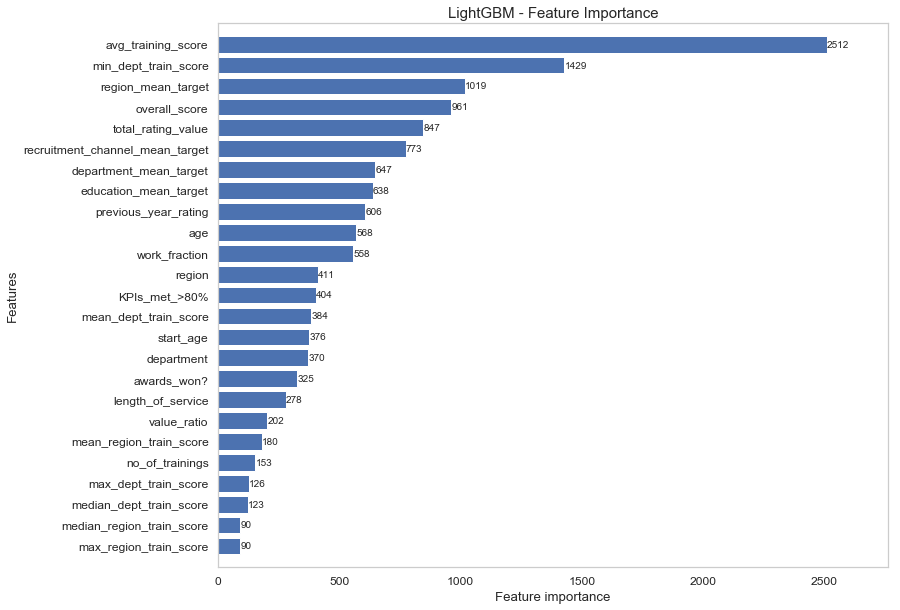

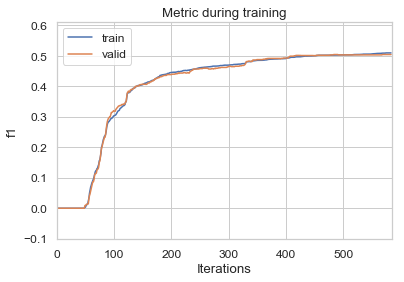

F1 Score:  0.5041186161449753
[6698  818 1375 1071  449  113   62   30   24    5   13   13    7   11   15   14   27   32   57  128]
[0.00088 0.05058 0.10028 0.14998 0.19968 0.24938 0.29907 0.34877 0.39847 0.44817 0.49787 0.54757 0.59727
 0.64697 0.69666 0.74636 0.79606 0.84576 0.89546 0.94516 0.99486]
Training until validation scores don't improve for 100 rounds.
[100]	train's f1: 0.299426	valid's f1: 0.284192
[200]	train's f1: 0.454527	valid's f1: 0.42892
[300]	train's f1: 0.479133	valid's f1: 0.454037
[400]	train's f1: 0.501814	valid's f1: 0.470403
[500]	train's f1: 0.508318	valid's f1: 0.475667
[600]	train's f1: 0.513783	valid's f1: 0.483242
[700]	train's f1: 0.519005	valid's f1: 0.486402
[800]	train's f1: 0.523413	valid's f1: 0.487578
Early stopping, best iteration is:
[731]	train's f1: 0.520477	valid's f1: 0.488751


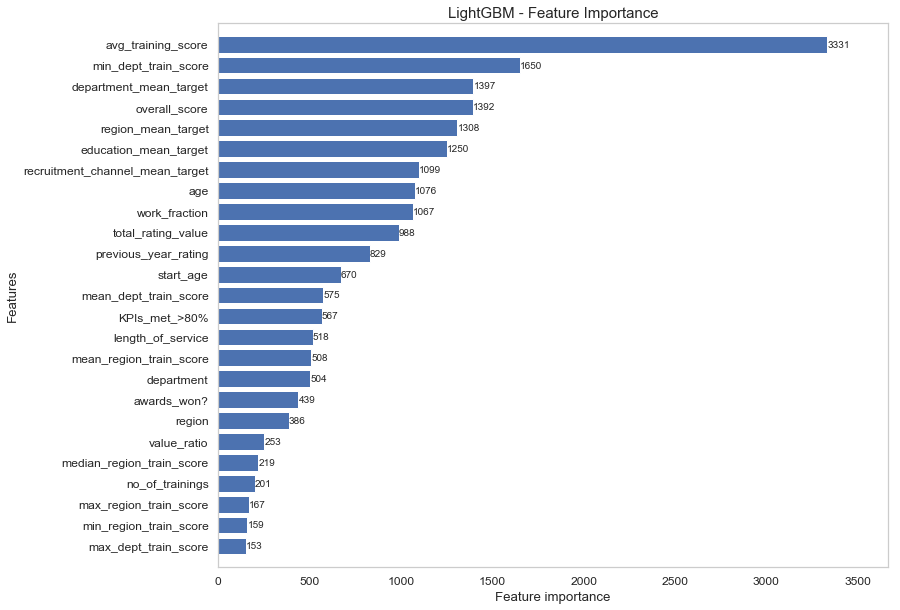

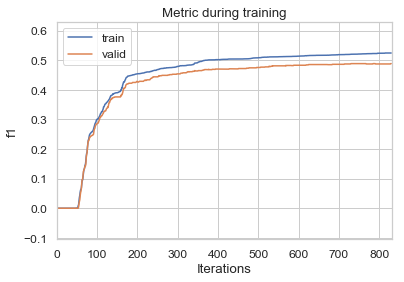

F1 Score:  0.4887509697439876
[6718  966 1391  919  395  137   62   21   20   10   11   10   11    3    7   15   16   34   46  170]
[0.00024 0.05016 0.10007 0.14999 0.19991 0.24982 0.29974 0.34966 0.39958 0.44949 0.49941 0.54933 0.59924
 0.64916 0.69908 0.749   0.79891 0.84883 0.89875 0.94866 0.99858]
Training until validation scores don't improve for 100 rounds.
[100]	train's f1: 0.30615	valid's f1: 0.28365
[200]	train's f1: 0.439331	valid's f1: 0.416598
[300]	train's f1: 0.476735	valid's f1: 0.449311
[400]	train's f1: 0.500402	valid's f1: 0.4672
[500]	train's f1: 0.509381	valid's f1: 0.47619
[600]	train's f1: 0.514808	valid's f1: 0.47981
[700]	train's f1: 0.51981	valid's f1: 0.482213
Early stopping, best iteration is:
[612]	train's f1: 0.515103	valid's f1: 0.482213


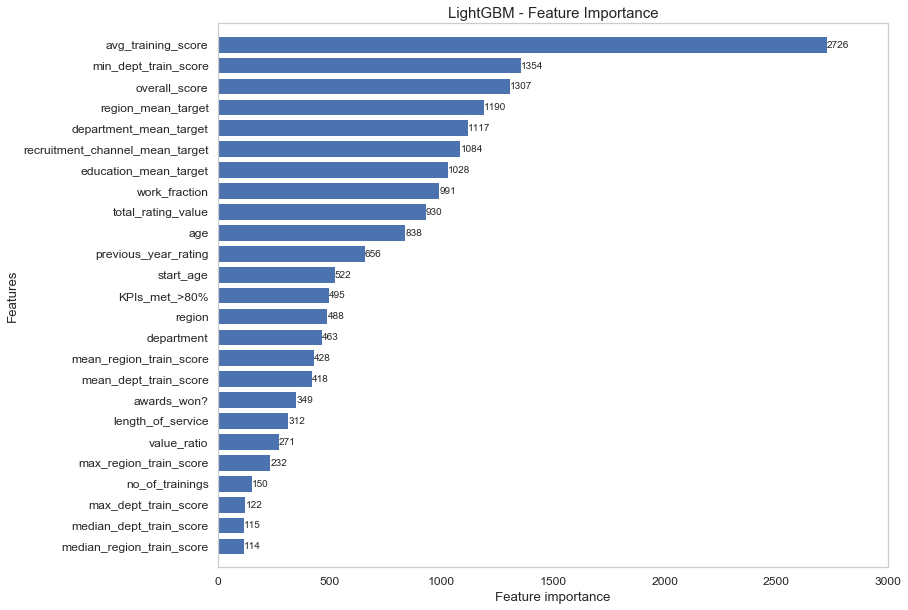

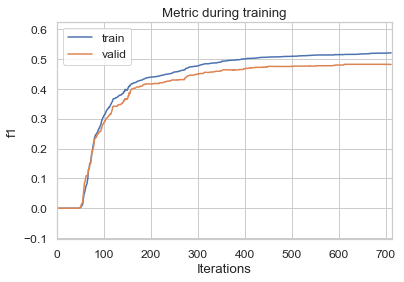

F1 Score:  0.48221343873517786
[6663  888 1437 1012  365  157   67   35   16    7    9    6   12    4    8    8   20   38   65  145]
[0.00048 0.05039 0.10031 0.15022 0.20013 0.25005 0.29996 0.34987 0.39979 0.4497  0.49961 0.54953 0.59944
 0.64935 0.69927 0.74918 0.79909 0.84901 0.89892 0.94883 0.99875]
Training until validation scores don't improve for 100 rounds.
[100]	train's f1: 0.312066	valid's f1: 0.332096
[200]	train's f1: 0.444856	valid's f1: 0.452055
[300]	train's f1: 0.475634	valid's f1: 0.476987
[400]	train's f1: 0.493336	valid's f1: 0.492129
[500]	train's f1: 0.506703	valid's f1: 0.494215
[600]	train's f1: 0.514028	valid's f1: 0.498765
[700]	train's f1: 0.522435	valid's f1: 0.500821
[800]	train's f1: 0.525209	valid's f1: 0.501229
[900]	train's f1: 0.528075	valid's f1: 0.506515
Early stopping, best iteration is:
[866]	train's f1: 0.527502	valid's f1: 0.507341


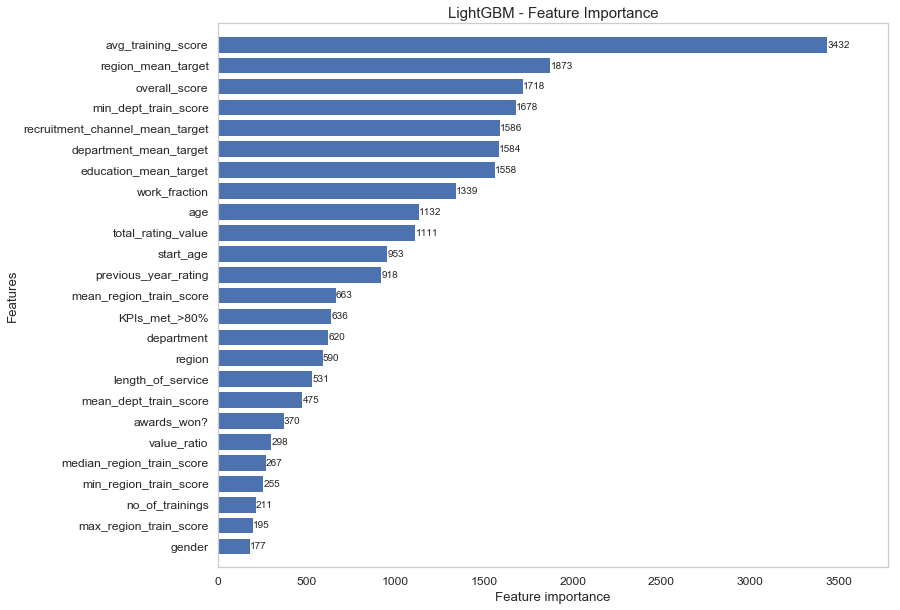

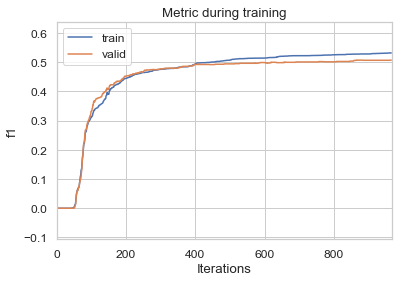

F1 Score:  0.5073409461663948
[6715  928 1334  966  393  179   51   33   25    9   11    9    6    5    6   10   17   26   52  186]
[0.00017 0.05014 0.10011 0.15007 0.20004 0.25    0.29997 0.34993 0.3999  0.44987 0.49983 0.5498  0.59976
 0.64973 0.69969 0.74966 0.79962 0.84959 0.89956 0.94952 0.99949]
Training until validation scores don't improve for 100 rounds.
[100]	train's f1: 0.321501	valid's f1: 0.292596
[200]	train's f1: 0.458066	valid's f1: 0.450363
[300]	train's f1: 0.479625	valid's f1: 0.480253
[400]	train's f1: 0.499094	valid's f1: 0.496875
[500]	train's f1: 0.503909	valid's f1: 0.498831
[600]	train's f1: 0.508989	valid's f1: 0.501943
[700]	train's f1: 0.514331	valid's f1: 0.505035
[800]	train's f1: 0.521498	valid's f1: 0.5058
Early stopping, best iteration is:
[705]	train's f1: 0.515218	valid's f1: 0.506192


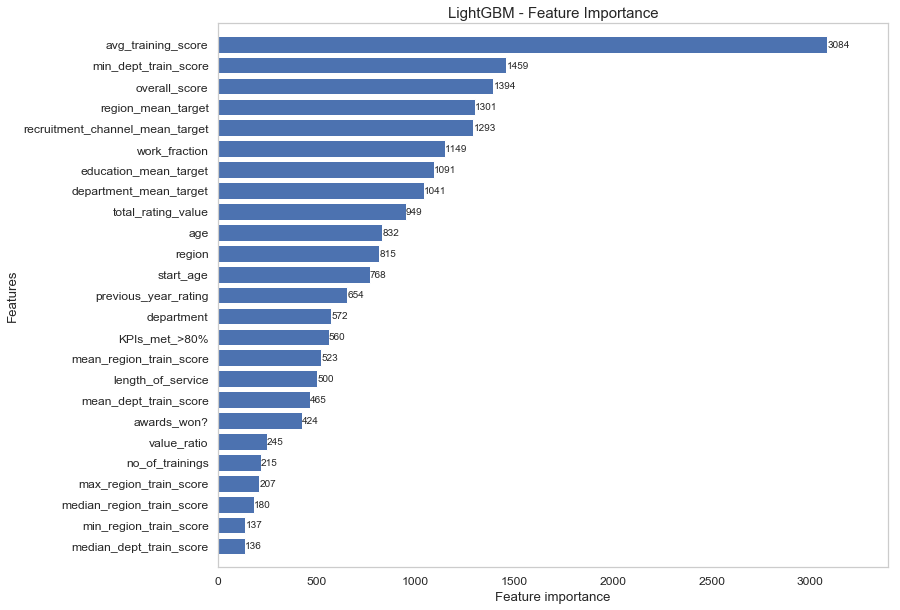

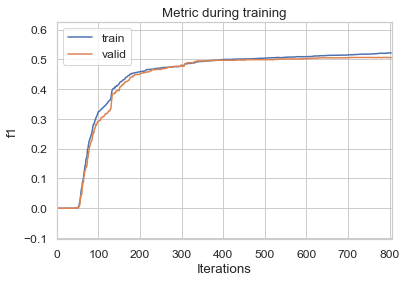

F1 Score:  0.5061919504643962
[6729  958 1294 1008  385  140   56   22   19   15    7    7    5   12   10   11   24   49   71  139]
[0.00037 0.0503  0.10023 0.15017 0.2001  0.25003 0.29997 0.3499  0.39984 0.44977 0.4997  0.54964 0.59957
 0.6495  0.69944 0.74937 0.79931 0.84924 0.89917 0.94911 0.99904]


In [37]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', metrics.f1_score(y_true, y_hat), True

err_lgb=[]
y_pred_tot_lgb=[]
fold=KFold(n_splits=5, shuffle=True)
for train_idx, test_idx in fold.split(df, y):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    params = {
        "objective" : "binary",
        "metric" : "f1",
        "boosting": "gbdt",
        "max_depth" : 6,
        "learning_rate" : 0.01,
        "feature_fraction" : 0.7,
        "bagging_fraction" : 0.7,
        "verbosity" : -1
    }
    evals_result = {}
    lgtrain = lgb.Dataset(X_train, y_train)
    lgval = lgb.Dataset(X_test, y_test)
    model = lgb.train(params
                      , lgtrain
                      , 3000
                      , valid_sets = [lgval, lgtrain]
                      , valid_names = ['valid', 'train']
                      , feval=lgb_f1_score
                      , evals_result=evals_result
                      , early_stopping_rounds=100
                      , verbose_eval=100
                     )
    # Top 25 features
    fig, ax = plt.subplots(figsize=(12,10))
    lgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
    ax.grid(False)
    plt.title("LightGBM - Feature Importance", fontsize=15)
    
    lgb.plot_metric(evals_result, metric='f1')
    plt.show()
    print("F1 Score: ",model.best_score['valid']['f1'])
    
    preds = model.predict(X_test, num_iteration=model.best_iteration)
    count, division = np.histogram(preds, bins=20)
    print(count)
    print(division)
    err_lgb.append(model.best_score['valid']['f1'])
    p = model.predict(df_test, num_iteration=model.best_iteration)
#     p = np.where(p < valid_threshold, 0, 1)
    y_pred_tot_lgb.append(p)

In [38]:
print(np.mean(err_lgb,0))

0.49772318425098633


In [39]:
y_pred_tot_lgb

[array([0.14618, 0.00222, 0.0011 , ..., 0.00249, 0.01011, 0.73867]),
 array([0.14823, 0.00125, 0.00047, ..., 0.00121, 0.00562, 0.90801]),
 array([0.1551 , 0.00186, 0.00071, ..., 0.00163, 0.00874, 0.86441]),
 array([0.15189, 0.00107, 0.00059, ..., 0.00103, 0.00732, 0.85239]),
 array([0.14734, 0.00158, 0.00096, ..., 0.00159, 0.00739, 0.84626])]

In [57]:
lgb_outcomes = np.where(np.mean(y_pred_tot_lgb, 0) < 0.25, 0, 1)
lgb_outcomes

array([0, 0, 0, ..., 0, 0, 1])

In [58]:
submission['is_promoted'] = lgb_outcomes
submission.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [59]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{Path}Submission_{file_timestamp}.csv', index=False)

### H20 AutoML

In [43]:
import h2o
from h2o.automl import H2OAutoML

In [44]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp31ijb96s
  JVM stdout: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp31ijb96s/h2o_bprudhvi_started_from_python.out
  JVM stderr: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp31ijb96s/h2o_bprudhvi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_bprudhvi_s1xumf
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [45]:
test = test.drop('is_promoted', axis=1)

In [46]:
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [47]:
X = train.columns
y = 'is_promoted'
X.remove(y)
X.remove('employee_id')

In [48]:
for df in (train, test):
    for col in categorical_columns:
        df[col] = df[col].asfactor()

train[y] = train[y].asfactor()

In [49]:
%%time
aml = H2OAutoML(max_models=30
                ,seed=2019
                ,max_runtime_secs=1800
                ,project_name="HR_Analytics"
               )
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 6.41 s, sys: 616 ms, total: 7.03 s
Wall time: 29min 7s


In [50]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190521_212159,0.910185,0.174378,0.303626,0.221006,0.0488436
StackedEnsemble_AllModels_AutoML_20190521_212159,0.909505,0.173457,0.296327,0.220883,0.0487893
GBM_1_AutoML_20190521_212159,0.909256,0.166318,0.30549,0.219745,0.048288
XGBoost_3_AutoML_20190521_212159,0.909118,0.1683,0.292933,0.220343,0.0485511
GBM_2_AutoML_20190521_212159,0.908629,0.166754,0.299875,0.220147,0.0484647
XGBoost_1_AutoML_20190521_212159,0.907893,0.16533,0.312105,0.219624,0.0482349
GBM_3_AutoML_20190521_212159,0.90749,0.167316,0.306646,0.220531,0.0486337
XGBoost_grid_1_AutoML_20190521_212159_model_1,0.906736,0.16662,0.309891,0.220211,0.0484927
XGBoost_grid_1_AutoML_20190521_212159_model_2,0.906278,0.170206,0.301266,0.220712,0.0487138
GBM_5_AutoML_20190521_212159,0.906229,0.168655,0.313046,0.221569,0.049093


In [51]:
aml_preds=aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [52]:
aml_preds=aml_preds.as_data_frame()

In [64]:
aml_submission = submission[['employee_id']]
aml_submission['is_promoted'] = aml_preds['predict']

In [65]:
aml_submission.tail()

,employee_id,is_promoted
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0
23489,5973,1


In [55]:
h2o.cluster().shutdown()

H2O session _sid_b548 closed.


In [66]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
aml_submission.to_csv(f'{Path}Submission_{file_timestamp}.csv', index=False)